# Multi-modal RAG with LangChain

## SetUp

Install the dependencies you need to run the notebook.

In [25]:
# for linux
# %sudo apt-get install poppler-utils tesseract-ocr libmagic-dev

# for mac
# %brew install poppler tesseract libmagic

In [26]:
%pip install -r requirements.txt


1476.73s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
print("wena wena perritoooo")

wena wena perritoooo


Start debugger

In [ ]:
import os

# keys for the services we will use

os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [51]:
import torch

print(torch.cuda.is_available())  # Debe devolver True
print(torch.cuda.get_device_name(0))  # Nombre de tu GPU

torch.cuda.empty_cache()

True
NVIDIA GeForce GTX 1660 Ti


## Extract the data

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be: Text, Images, Tables, etc.

### Partition PDF tables, text, and images

In [61]:
from unstructured.partition.pdf import partition_pdf

output_path = "./research_docs/"
image_output_path = output_path + "images/"
file_path = output_path + "covid192.pdf"
file_path_2 = output_path + "Dialnet-InvestigacionCientificaDeCOVID19DesdeElAmbitoEmpre-9735586.pdf"
file_path_3 = output_path + "Evidence_Summary_of_Sputnik_V_Gam-COVID-Vac_COVID-19_Vaccine_12_April_2021 TABLAS.pdf"
file_path_4 = output_path + "TABLAS CICLO_MEDIO_Y_SUPERIOR-_Cuadros_comparativos.pdf"

# Reference: https://docs.unstructured.io/open-source/core-functionality/chunking
chunks = partition_pdf(
    filename=file_path_4,
    infer_table_structure=True,  # extract tables
    # skip_infer_table_types=False,
    strategy="hi_res",  # mandatory to infer tables
    extract_image_block_types=["Image", "Table"],  # Add 'Table' to list to extract image of tables
    image_output_dir_path=image_output_path,  # if None, images and tables will saved in base64
    extract_image_block_to_payload=True,  # if true, will extract base64 for API usage
    chunking_strategy="by_title",  # or 'basic'
    max_characters=10000,  # defaults to 500
    combine_text_under_n_chars=2000,  # defaults to 0
    new_after_n_chars=6000,
    # extract_images_in_pdf=True,          # deprecated
)

In [53]:
# We get 2 types of elements from the partition_pdf function
set([str(type(el)) for el in chunks])

{"<class 'unstructured.documents.elements.CompositeElement'>"}

In [54]:
# Each CompositeElement containes a bunch of related elements.
# This makes it easy to use these elements together in a RAG pipeline.

print(f"size: {len(chunks)} chunks: {chunks}")
# print(chunks[0].metadata.to_dict())

size: 3 chunks: [<unstructured.documents.elements.CompositeElement object at 0x7fd1c22c5990>, <unstructured.documents.elements.CompositeElement object at 0x7fd1c22c6e00>, <unstructured.documents.elements.CompositeElement object at 0x7fd1c22c61d0>]


In [55]:
# This is what an extracted image looks like.
# It contains the base64 representation only because we set the param extract_image_block_to_payload=True
elements = chunks[0].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]
len(chunk_images)

14

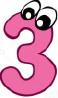

In [57]:
import base64
from IPython.display import Image, display


def display_base64_image(base64_code):
    # Decode the base64 string to binary
    image_data = base64.b64decode(base64_code)
    # Display the image
    display(Image(data=image_data))


imageb64 = chunk_images[10].to_dict()["metadata"]["image_base64"]

display_base64_image(imageb64)

In [ ]:
from PyPDF2 import PdfReader 
import tabula

  
reader = PdfReader(file_path_4)

num_pages=len(reader.pages)
print(f"Number of pages: {num_pages}")

# Extract tables from the PDF, first reading with PyPDF2
tables = []
for i in range(1,num_pages+1):
    try:
        # get tables from given page
        tables=tabula.read_pdf(file_path_4, pages=i)
        # check if tables exist
        if len(tables)>0:
            for table in tables:# loop through each table
                # check if the table has at least 1 row and 2 columns
                if table.shape[0]>1 and table.shape[1]>1:
                    table_before=table.copy()
                    # remove empty columns
                    table=table.dropna(axis=1, how='all')
                    # remove empty rows
                    table=table.dropna(axis=0, how='all')
                    # check if the table has at least 1 row and 2 columns
                    if table.shape[0]>1 and table.shape[1]>1:
                        # check if the table has at least 1 row and 2 columns
                        print(f"Table found on page {i}:")
                        print(table)
                        # save the table to a CSV file
                        table.to_csv(f"table_page_{i}.csv", index=False)
                    else:
                        print(f"Table on page {i} is empty after cleaning.")
                else:
                    print(f"Table on page {i} is empty.")
    except Exception as e:
        print(f"Error reading page {i}: {e}")
        continue



Number of pages: 7
Error reading page 1: module 'tabula' has no attribute 'read_pdf'
Error reading page 2: module 'tabula' has no attribute 'read_pdf'
Error reading page 3: module 'tabula' has no attribute 'read_pdf'
Error reading page 4: module 'tabula' has no attribute 'read_pdf'
Error reading page 5: module 'tabula' has no attribute 'read_pdf'
Error reading page 6: module 'tabula' has no attribute 'read_pdf'
Error reading page 7: module 'tabula' has no attribute 'read_pdf'
Error reading page 1: module 'tabula' has no attribute 'read_pdf'
Error reading page 2: module 'tabula' has no attribute 'read_pdf'
Error reading page 3: module 'tabula' has no attribute 'read_pdf'
Error reading page 4: module 'tabula' has no attribute 'read_pdf'
Error reading page 5: module 'tabula' has no attribute 'read_pdf'
Error reading page 6: module 'tabula' has no attribute 'read_pdf'
Error reading page 7: module 'tabula' has no attribute 'read_pdf'


### Separate extracted elements into tables, text, and images

In [59]:
# separate tables from texts
tables = []
texts = []

print(f"size: {len(chunks)} chunks: {chunks[1].metadata.orig_elements}")
for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)

    if "CompositeElement" in str(type((chunk))):
        texts.append(chunk)

print(f"size: {len(tables)} tables: {tables}")

size: 3 chunks: [<unstructured.documents.elements.Title object at 0x7fd1c206fb80>, <unstructured.documents.elements.Image object at 0x7fd1c2068040>, <unstructured.documents.elements.NarrativeText object at 0x7fd1c2068610>, <unstructured.documents.elements.Image object at 0x7fd1c206ef20>, <unstructured.documents.elements.Image object at 0x7fd1cbff8340>, <unstructured.documents.elements.Image object at 0x7fd1c2069270>, <unstructured.documents.elements.Title object at 0x7fd1c2069570>, <unstructured.documents.elements.Image object at 0x7fd1c2068d00>, <unstructured.documents.elements.NarrativeText object at 0x7fd1c20688e0>, <unstructured.documents.elements.Title object at 0x7fd1c2068be0>, <unstructured.documents.elements.NarrativeText object at 0x7fd1c2068f40>, <unstructured.documents.elements.NarrativeText object at 0x7fd1c206a2c0>, <unstructured.documents.elements.Title object at 0x7fd14b5b2650>, <unstructured.documents.elements.NarrativeText object at 0x7fd14b5b3d60>, <unstructured.docum

In [26]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if "Image" in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

#### Check what the images look like

In [28]:
display_base64_image(images[0])

IndexError: list index out of range

## Summarize the data

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

### Text and Table summaries

We don't need a multimodal model to generate the summaries of the tables and the text. I will use open source models available on Groq.

In [15]:
%pip install -Uq langchain-groq


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [30]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

from langchain_openai import ChatOpenAI
import os


In [34]:
# Prompt 1
prompt_text1 = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
# Prompt 2
prompt_text2 = """
You are an assistant tasked with summarizing tables and only tables.
Give a concise summary of the table, detailing the column name and the value.

Respond only with the summary, no additionnal comment.
Do not start your message by saying "Here is a summary" or anything like that.
Just give the summary as it is.

Table or text chunk: {element}

"""
prompt = ChatPromptTemplate.from_template(prompt_text2)

# Summary chain
# model = ChatGroq(temperature=0.5, model="llama-3.1-8b-instant")
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]
model = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY, model="gpt-4o-mini")
summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

In [37]:
# Summarize text
# text_summaries = summarize_chain.batch(texts, {"max_concurrency": 3})

# Summarize tables
tables_html = [table.metadata.text_as_html for table in tables]
table_summaries = summarize_chain.batch(tables_html, {"max_concurrency": 3})

In [38]:
# text_summaries
table_summaries

[]

### Image summaries

We will use gpt-4o-mini to produce the image summaries.

In [ ]:
%pip install -Uq langchain_openai

Note: you may need to restart the kernel to use updated packages.


In [25]:
from langchain_openai import ChatOpenAI

prompt_template = """Describe the image in detail. For context,
                  the image is part of a research paper explaining the content of the image. Be specific about graphics."""
messages = [
    (
        "user",
        [
            {"type": "text", "text": prompt_template},
            {
                "type": "image_url",
                "image_url": {"url": "data:image/jpeg;base64,{image}"},
            },
        ],
    )
]

prompt = ChatPromptTemplate.from_messages(messages)

chain = prompt | ChatOpenAI(model="gpt-4o-mini") | StrOutputParser()


image_summaries = chain.batch(images)

In [26]:
image_summaries

['The image features a logo representing the "Gaceta Médica Boliviana," which is a medical journal from Bolivia. The logo has a predominantly blue background, which conveys a sense of professionalism and trust. \n\nIn the logo, the letters "G," "M," and "B" are prominently displayed in white, arranged vertically in a stylized manner. The letters are intertwined, creating a cohesive graphic element that symbolizes the journal\'s identity.\n\nAbove the initials, the full name "GACETA MÉDICA BOLIVIANA" is written out in uppercase white letters, spanning the width of the logo. This reinforces the recognition of the journal’s purpose and scope. \n\nAt the bottom right, the phrase "Fundada en 1943" is noted, subtly indicating the journal\'s historical significance and longevity in the field of medical publishing.\n\nOverall, the graphic design is clean and minimalistic, focusing on clarity and easy recognition, aligning with the journal\'s academic and professional context.',
 'The image sho

In [29]:
print(image_summaries[3])

The image appears to be a minimalist logo or graphic representation, likely associated with a website or organization. It includes a combination of text and a symbolic graphic element.

1. **Text Elements:**
   - The top part features the abbreviation "UAEM," which might refer to an institution or organization.
   - Below it is the web address "re&alyc.org." The text includes a stylized "&" symbol, which is integrated into the text flow, suggesting a connection between entities or concepts.

2. **Graphic Elements:**
   - In the upper right corner, there is a simple geometric shape, possibly resembling a flag or some other indicator. This adds a layer of visual interest without overwhelming the overall design.

3. **Color and Style:**
   - The image has a monochromatic or very softly contrasted color palette, likely using light gray against a white background, contributing to a clean and modern aesthetic.

4. **Overall Design:**
   - The logo maintains a minimalist style, focusing on cl

## Load data and summaries to vectorstore

### Create the vectorstore

In [ ]:
import uuid
from langchain.vectorstores import Chroma
from langchain.storage import InMemoryStore
from langchain.schema.document import Document
from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever

# The vectorstore to use to index the child chunks
vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())

# The storage layer for the parent documents
store = InMemoryStore()
id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=vectorstore,
    docstore=store,
    id_key=id_key,
)

/var/folders/lh/7g2mv_x16p79z2rd9jqxqx_w0000gn/T/ipykernel_92745/278287695.py:9: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="multi_modal_rag", embedding_function=OpenAIEmbeddings())
/var/folders/lh/7g2mv_x16p79z2rd9jqxqx_w0000gn/T/ipykernel_92745/278287695.py:9: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="multi

### Load the summaries and link the to the original data

In [ ]:
# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=summary, metadata={id_key: doc_ids[i]}) for i, summary in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=summary, metadata={id_key: table_ids[i]}) for i, summary in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

# Add image summaries
img_ids = [str(uuid.uuid4()) for _ in images]
summary_img = [
    Document(page_content=summary, metadata={id_key: img_ids[i]}) for i, summary in enumerate(image_summaries)
]
retriever.vectorstore.add_documents(summary_img)
retriever.docstore.mset(list(zip(img_ids, images)))

### Check retrieval

In [ ]:
# Retrieve
docs = retriever.invoke(
    "who are the authors of the paper?"
)

In [ ]:
for doc in docs:
    print(str(doc) + "\n\n" + "-" * 80)

[36] Christian Szegedy, Vincent Vanhoucke, Sergey Ioffe, Jonathon Shlens, and Zbigniew Wojna. Rethinking the inception architecture for computer vision. CoRR, abs/1512.00567, 2015.

[37] Vinyals & Kaiser, Koo, Petrov, Sutskever, and Hinton. Grammar as a foreign language. In Advances in Neural Information Processing Systems, 2015.

[38] Yonghui Wu, Mike Schuster, Zhifeng Chen, Quoc V Le, Mohammad Norouzi, Wolfgang Macherey, Maxim Krikun, Yuan Cao, Qin Gao, Klaus Macherey, et al. Google’s neural machine translation system: Bridging the gap between human and machine translation. arXiv preprint arXiv:1609.08144, 2016.

[39] Jie Zhou, Ying Cao, Xuguang Wang, Peng Li, and Wei Xu. Deep recurrent models with fast-forward connections for neural machine translation. CoRR, abs/1606.04199, 2016.

[40] Muhua Zhu, Yue Zhang, Wenliang Chen, Min Zhang, and Jingbo Zhu. Fast and accurate shift-reduce constituent parsing. In Proceedings of the 51st Annual Meeting of the ACL (Volume 1: Long Papers), pages

## RAG pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from base64 import b64decode


def parse_docs(docs):
    """Split base64-encoded images and texts"""
    b64 = []
    text = []
    for doc in docs:
        try:
            b64decode(doc)
            b64.append(doc)
        except Exception as e:
            text.append(doc)
    return {"images": b64, "texts": text}


def build_prompt(kwargs):

    docs_by_type = kwargs["context"]
    user_question = kwargs["question"]

    context_text = ""
    if len(docs_by_type["texts"]) > 0:
        for text_element in docs_by_type["texts"]:
            context_text += text_element.text

    # construct prompt with context (including images)
    prompt_template = f"""
    Answer the question based only on the following context, which can include text, tables, and the below image.
    Context: {context_text}
    Question: {user_question}
    """

    prompt_content = [{"type": "text", "text": prompt_template}]

    if len(docs_by_type["images"]) > 0:
        for image in docs_by_type["images"]:
            prompt_content.append(
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{image}"},
                }
            )

    return ChatPromptTemplate.from_messages(
        [
            HumanMessage(content=prompt_content),
        ]
    )


chain = (
    {
        "context": retriever | RunnableLambda(parse_docs),
        "question": RunnablePassthrough(),
    }
    | RunnableLambda(build_prompt)
    | ChatOpenAI(model="gpt-4o-mini")
    | StrOutputParser()
)

chain_with_sources = {
    "context": retriever | RunnableLambda(parse_docs),
    "question": RunnablePassthrough(),
} | RunnablePassthrough().assign(
    response=(
        RunnableLambda(build_prompt)
        | ChatOpenAI(model="gpt-4o-mini")
        | StrOutputParser()
    )
)

In [ ]:
response = chain.invoke(
    "What is the attention mechanism?"
)

print(response)

The attention mechanism is a function that maps a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, with the weights determined by a compatibility function that measures how well the query aligns with each key.

In mathematical terms, the attention function can be expressed as:

\[ \text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V \]

Here, \(Q\) represents the queries, \(K\) the keys, and \(V\) the values. The dot products of the queries and keys are scaled by the square root of the dimension of the keys (\(d_k\)) to prevent large values that could push the softmax function into regions with small gradients. This attention mechanism allows the model to focus on different parts of the input sequence when producing an output, enhancing its ability to handle dependencies and context within the data. 

Additionally, multi-head attention extends th

Response: Multi-head attention is a mechanism used in the Transformer model that allows the model to focus on different parts of the input sequence simultaneously. Instead of using a single attention function, multi-head attention uses multiple attention heads, each performing attention with different, learned linear projections of the queries, keys, and values. 

Here's a breakdown of how it works:

1. **Linear Projections**: The queries (Q), keys (K), and values (V) are projected into different subspaces using learned linear transformations. Each head has its own set of projections.

2. **Parallel Attention**: Each head computes attention independently, allowing the model to attend to various representation subspaces from different positions in the input sequence.

3. **Concatenation**: The outputs from all heads are concatenated together.

4. **Final Linear Projection**: The concatenated output is then projected again to produce the final output.

This approach enables the model to 

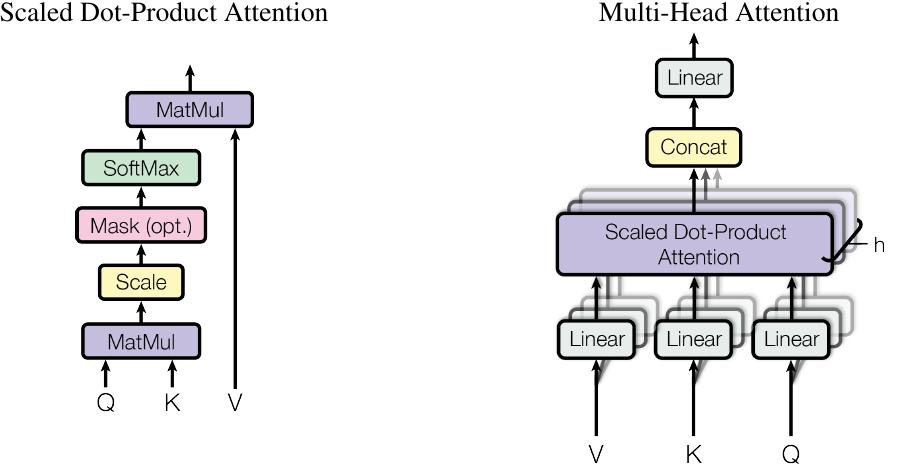

In [ ]:
response = chain_with_sources.invoke(
    "What is multihead?"
)

print("Response:", response['response'])

print("\n\nContext:")
for text in response['context']['texts']:
    print(text.text)
    print("Page number: ", text.metadata.page_number)
    print("\n" + "-"*50 + "\n")
for image in response['context']['images']:
    display_base64_image(image)

## References

- [LangChain Inspiration](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_structured_and_multi_modal_RAG.ipynb?ref=blog.langchain.dev)
- [Multivector Storage](https://python.langchain.com/docs/how_to/multi_vector/)